<a href="https://colab.research.google.com/github/roshan-k-patel/APCOMP2090A-workbooks/blob/master/209a_section10_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science

# Section 10: Decision Trees

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
<hr style='height:2px'>

In [ ]:
import os
import subprocess

# Define the name of the zip file containing your assets
assets_zip_name = "notebook_assets.zip"

# Define the directories that should be present after extraction
expected_dirs = ["data", "fig"]

# Construct the raw GitHub URL for the zip file
github_raw_url = f"https://github.com/Harvard-CS1090A/2025-public/raw/main/sec10/{assets_zip_name}"

# Check if running in Google Colab
if 'COLAB_GPU' in os.environ:
    print("Running in Google Colab. Checking for necessary files...")

    # Check if the expected directories already exist
    all_dirs_exist = True
    for d in expected_dirs:
        if not os.path.isdir(d):
            all_dirs_exist = False
            break

    if all_dirs_exist:
        print("Required directories already exist. Skipping download.")
    else:
        print(f"Required directories not found. Downloading {assets_zip_name} from GitHub...")

        try:
            # Download the zip file
            subprocess.run(['wget', '-q', github_raw_url], check=True)
            print(f"Downloaded {assets_zip_name}.")

            # Unzip the file
            subprocess.run(['unzip', '-q', assets_zip_name], check=True)
            print(f"Extracted {assets_zip_name}.")

            # Clean up the zip file
            subprocess.run(['rm', assets_zip_name], check=True)
            print(f"Removed {assets_zip_name}.")

            print("All necessary files are now available.")

        except subprocess.CalledProcessError as e:
            print(f"Error during file download or extraction: {e}", file=sys.stderr)
        except FileNotFoundError:
            print("wget or unzip command not found. Please ensure they are installed.", file=sys.stderr)

else:
    print("Not running in Google Colab. Assuming files are locally available.")

Not running in Google Colab. Assuming files are locally available.


---------
## Decision Tree Conceptual Review

#### The Idea: Decision Trees are just flowcharts and are interpretable!

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/flowchart.png?raw=1" alt="how to fix anything" width="50%"/>


It turns out that simple flow charts can be formulated as mathematical models for classification and these models have the properties we desire:
 - interpretable by humans
 - have sufficiently complex decision boundaries
 - the decision boundaries are locally linear, each component of the decision boundary is simple to describe mathematically.

----------

#### Let's review some theory.

How do we build decision trees? We use a greedy approach:
 1. Start with an empty decision tree (undivided feature space)
 2. Choose the ‘optimal’ predictor on which to split and choose the ‘optimal’ threshold value for splitting by applying a **splitting criterion (1)**
 3. Recurse on on each new node until **stopping condition (2)** is met

For classification, we label each region in the model with the label of the class to which the majority of the points within the region belong.

#### So we need a (1) splitting criterion and a (2) stopping condition:

  #### (1) Splitting criterion
<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/split1.png?raw=1" alt="split1" width="70%"/>

---

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/classification%20error.png?raw=1" alt="classification error"/>

---
<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/split2.png?raw=1" alt="split2" width="70%"/>

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/tree_loss.png?raw=1" alt="tree_adj"/>

#### (2) Stopping condition

If we don’t terminate the decision tree learning algorithm manually, the tree will continue to grow until each region defined by the model possibly contains exactly one training point (and the model attains 100% training accuracy). **Not stopping while building a deeper and deeper tree = 100% training accuracy; What will your test accuracy be? What can we do to fix this?**

To prevent the **overfitting** from happening, we could
- Stop the algorithm at a particular depth. (=**not too deep**)
- Don't split a region if all instances in the region belong to the same class. (=**stop when subtree is pure**)
- Don't split a region if the number of instances in the sub-region will fall below pre-defined threshold (min_samples_leaf). (=**not too specific/small subtree**)
- Don't use too many splits in the tree (=**not too many splits / not too complex global tree**)
- Be content with <100% accuracy training set...

-------------

#### Done with theory, let's get started

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import tree
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix
from sklearn import datasets

#new model objects
from sklearn.tree import DecisionTreeClassifier


pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

np.random.seed(42)

## Decision Tree from scratch

In this exercise we'll build a portion of a decision tree classifier from scratch and compare our results to the `sklearn` implementation.

Our toy dataset consists of two predictors and a binary class label.

In [ ]:
# Read the dataframe in
tree_df = pd.read_csv('data/two_classes.csv')
# Inspect the top 5 rows
tree_df.head()

,x1,x2,y
0,143,139,1
1,117,130,0
2,235,331,1
3,230,298,1
4,280,277,0


Visualizing the data we can imagine what the ideal decision boundaries might look like.

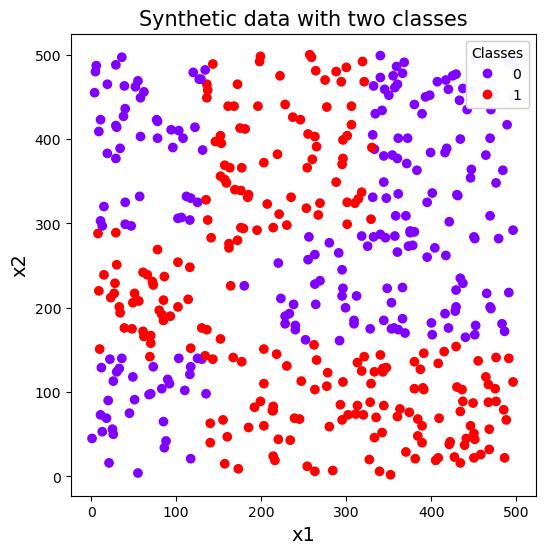

In [ ]:
# Plot the data to visualize class patterns

# Create figure of specific size and the axes objects
fig, ax = plt.subplots(figsize=(6,6))

# Scatter the data points
# Other colormaps could be found here:
# https://stackoverflow.com/questions/34314356/how-to-view-all-colormaps-available-in-matplotlib
scatter = ax.scatter(tree_df['x1'], tree_df['x2'], c=tree_df['y'], cmap='rainbow')

# Create a legend object with title "Classes" and specified location on the plot
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Add labeling to the plot
ax.set_xlabel('x1', fontsize='14')
ax.set_ylabel('x2', fontsize='14')
ax.set_title('Synthetic data with two classes', fontsize='15');

### Step 1. Establish the Root Node.
First, we need to decide what predictor to use for the 1st split and what threshold value we are splitting on. The choosen predictor & threshold will define the **Root Node** of our tree.

For candidate splits we try every unique value of each of the predictors.

To evaluate the candidate splits we'll use the Gini Impurity Index.

Because we will compare our results to `sklearn` at the end, let's use the same conventions as their `DecisionTreeClassifier`.

* Splitting conditions are stated in terms of "<= threshold"
* Points for which the splitting condition is **true** are placed in the **left** 'child' or 'leaf'. Those for which the condition is false are placed in the right child.

This differs from the convention used in the lecture slides.

In [ ]:
# Function that calculates the total Gini impurity index for each value provided
def get_total_gini(predictor_values, pred_name, df):
    '''
    Parameters: an array of _unique_ predictor values,
                a name of the predictor (String),
                a corresponding dataframe object.
    Returns: an array of total Gini index for each provided predictor value.
    '''
    total_gini = []

    # try each value as a potential split location
    for val in predictor_values:
        # NOTE: you'll want to use some strategy to avoid division by 0

        # Left Leaf
        # counts of each class (1 or 0) to the left of candidate split
        left_1 = np.sum(df[df[pred_name] <= val]['y']==1) # SOLUTION
        left_0 = np.sum(df[df[pred_name] <= val]['y']==0) # SOLUTION

        # total number of points on the left
        N_left = max(1e-5, left_1+left_0) # SOLUTION
        # Gini impurity for the left leaf
        gini_left = 1 - (left_1/N_left)**2 - (left_0/N_left)**2 # SOLUTION

        # Right Leaf
        # counts of each class (1 or 0) to the right of candidate split
        right_1 = np.sum(df[df[pred_name] > val]['y']==1) # SOLUTION
        right_0 = np.sum(df[df[pred_name] > val]['y']==0) # SOLUTION
        # total number of points on the right
        N_right = max(1e-5, right_1 + right_0) # SOLUTION
        # Gini impurity for the right leaf
        gini_right = 1 - (right_1/N_right)**2 - (right_0/N_right)**2 # SOLUTION

        # total number of points in both leaves
        N_total = N_left + N_right # SOLUTION
        # Finally append the total weighted gini impurity to total_gini
        # total_gini.append(___)
        # BEGIN SOLUTION
        total_gini.append(N_left/N_total * gini_left
                          + N_right/N_total * gini_right)
        # END SOLUTION

    return total_gini

The `get_total_gini` function takes *unique* predictor values as its first argument. Define these below (and consider why we want to use unique values here).

In [ ]:
### edTest(test_x1_unique_values) ###

# Get unique values of x1
x1_unique = np.unique(tree_df.x1.values) # SOLUTION

In [ ]:
### edTest(test_x2_unique_values) ###

# Get unique values of x2
x2_unique = np.unique(tree_df.x2.values) # SOLUTION

Now use `get_total_gini` to find the gini scores for each predictor.

In [ ]:
### edTest(test_x1_total_gini) ###

# get total Gini index for x1
x1_total_gini = get_total_gini(x1_unique, 'x1', tree_df) # SOLUTION

In [ ]:
### edTest(test_x2_total_gini) ###

# get total Gini index for x2
x2_total_gini = get_total_gini(x2_unique, 'x2', tree_df) # SOLUTION

Inspect the visualization of your results below.

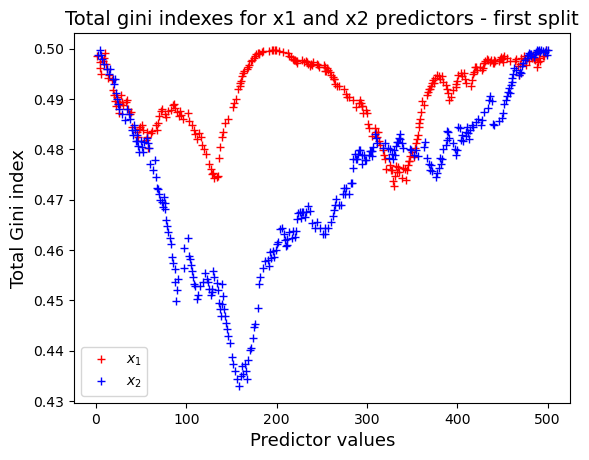

In [ ]:
# plot the resulting total Gini indexes for each predictor
plt.plot(x1_unique, x1_total_gini, 'r+', label="$x_1$")
plt.plot(x2_unique, x2_total_gini, 'b+', label="$x_2$")
plt.xlabel("Predictor values", fontsize="13")
plt.ylabel("Total Gini index", fontsize="13")
plt.title("Total gini indexes for x1 and x2 predictors - first split", fontsize="14")
plt.legend()
plt.show()

In [ ]:
def report_splits(x1_unique, x2_unique, x1_total_gini, x2_total_gini):
     # predictor providing the split with the lowest gini (x1=0, x2=1)
     best_pred = np.argmin([min(x1_total_gini), min(x2_total_gini)])
     # index of lowest gini score for best predictor
     best_gini_idx = np.argmin([x1_total_gini, x2_total_gini][best_pred])
     # best predictor value corresponding to that lowest gini score
     best_pred_value = [x1_unique, x2_unique][best_pred][best_gini_idx]
     print("The lowest total gini score is achieved when splitting on "+\
          f"{['x1','x2'][best_pred]} at the value {best_pred_value}.")

report_splits(x1_unique, x2_unique, x1_total_gini, x2_total_gini)

The lowest total gini score is achieved when splitting on x2 at the value 158.


**Getting the 1st split threshold**

The output above describes the best split among all the candidates. Each candidate split corresponded to a unique predictor value. **But this predictor value will not be our threshold value**. Instead, we use the midpoint *between* this value and the next highest unique value for that predictor in the training data (in this exercise, all data is training data).

In [ ]:
# Find the threshold to split on
def get_threshold(unique_values, gini_scores):
    # index of lowest gini score
    idx = np.argmin(gini_scores)
    # threshold is the midpoint between
    # the predictor value resulting in lowest gini split
    # and the next highest unique predictor value
    # (you can assume values are sorted)
    threshold = (unique_values[idx] + unique_values[idx+1])/2
    return threshold

x2_threshold = get_threshold(x2_unique, x2_total_gini) # SOLUTION
print(f"Our threshold will be {x2_threshold}")

# Test that we got the expected result
np.testing.assert_allclose(159.5, x2_threshold)

Our threshold will be 159.5


### Step 2. Let's make our first split.

We'll use some helper functions to assist with plotting the decision regions we get from our first split.

`get_split_labels` determines the classification within each region based on the majority class within that region in the training data.

`predict_class` takes vectors of `x1` and `x2` values and returns a vector of predicted class labels. We predict on dummy values created with `np.meshgrid` and use the results with `plt.contourf` to plot colored decision regions.

In keeping with the convention used by `sklearn`, all points in our root node that are less than or equal to our threshold will be placed in the 'left' childe node. And the rest will go on in the 'right' child node.

In [ ]:
def get_split_labels(splits):
    '''
    Parameters:
        splits: List of ('predictor name', threshold) tuples
                Ex: [('x1', 42), ('x2', 109)]
    Returns: List of dictionaries, one for each split.
             Dictionaries contain class labels for each side of the split
    '''
    split_labels = []
    region = tree_df
    for pred, thresh in splits:
        region_labels = {
            'left': region.loc[region[pred] <= thresh, 'y'].mode().values[0],
            'right': region.loc[region[pred] > thresh, 'y'].mode().values[0]
        }
        split_labels.append(region_labels)
        region = region[region[pred] <= thresh]
    return split_labels

# Example of how get_split_labels works
splits = [('x2', x2_threshold)]
split_labels = get_split_labels(splits)
print('class labels for the children of the root node:', split_labels)

class labels for the children of the root node: [{'left': np.int64(1), 'right': np.int64(0)}]


In [ ]:
def predict_class(x1, x2, splits):
    # get split labels to use when predicting
    split_labels = get_split_labels(splits)
    y_hats = []
    # iterate over each data point
    for x1_i, x2_i in zip(x1.ravel(), x2.ravel()):
        # dict lets us specify a predictor based on split rule
        obs = {'x1': x1_i, 'x2': x2_i}
        # apply each split rule
        for n_split, (pred, thresh) in enumerate(splits):
            # left
            if obs[pred] <= thresh:
                if n_split == len(splits)-1:
                    y_hats.append(split_labels[n_split]['left'])
            # right
            else:
                y_hats.append(split_labels[n_split]['right'])
                break
    return np.array(y_hats)

Now we are ready to plot our split.

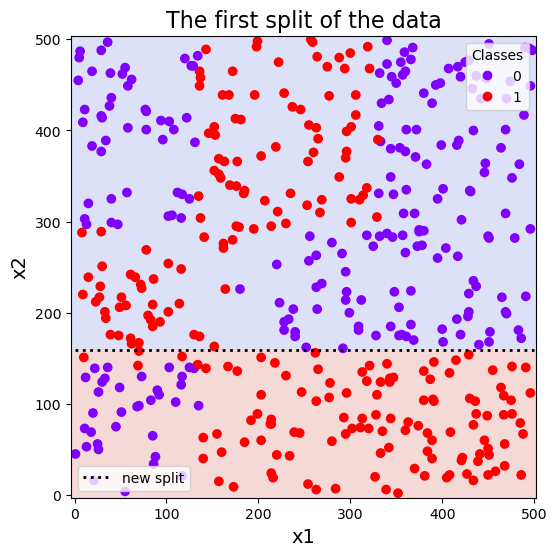

In [ ]:
# Plot the split:
# Create figure of specific size and the axes objects
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter the data points
# Other colormaps could be found here:
# https://stackoverflow.com/questions/34314356/how-to-view-all-colormaps-available-in-matplotlib
scatter = ax.scatter(tree_df['x1'], tree_df['x2'], c=tree_df['y'], cmap='rainbow')

# Create a legend object with title "Classes" and specified location on the plot
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Split line
ax.hlines(x2_threshold, xmin=0, xmax=500,
          color ='black', lw = 2, ls=':', label='new split')
ax.legend()

# Add labeling to the plot
ax.set_xlabel('x1', fontsize='14')
ax.set_ylabel('x2', fontsize='14')
ax.set_title('The first split of the data', fontsize='16')

# Plot decision regions
# dummy x1 & x2 grid values to predict on
eps = 5 # padding for the grid
xx1, xx2 = np.meshgrid(np.arange(tree_df['x1'].min()-eps, tree_df['x1'].max()+eps, 1),
                       np.arange(tree_df['x2'].min()-eps, tree_df['x2'].max()+eps, 1))
# predict class labels on grid points
class_pred = predict_class(xx1, xx2, splits)
# contour plot for decision regions
plt.contourf(xx1, xx2, class_pred.reshape(xx1.shape), alpha=0.2, zorder=-1, cmap=plt.cm.coolwarm);

We'll create a new DataFrame, `first_split_df` in which all `x2` values are less than or equal to `x2_threshold`.

This DataFrame contains the points that end up in the region corresponding to the "left leaf" or "left child" of the root node. We'll use it in the next section where we further split this region.


In [ ]:
first_split_df  = tree_df[tree_df['x2'] <= x2_threshold] # SOLUTION
# Peak at the result
first_split_df.head()

,x1,x2,y
0,143,139,1
1,117,130,0
14,265,138,1
18,230,131,1
20,140,63,1


### Step 3. Making the second split.

Now we'll run the same function as above using our new df.

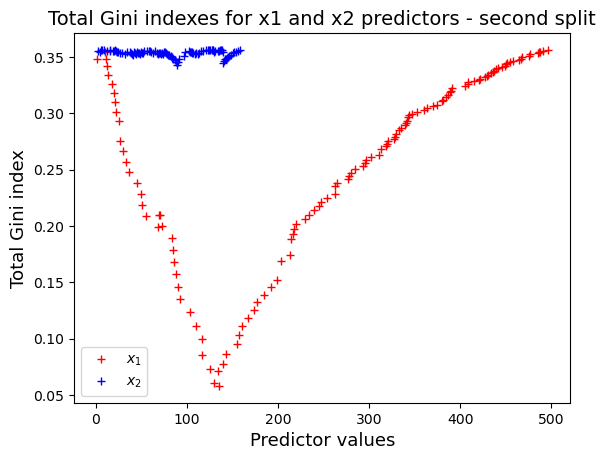

In [ ]:
# provide unique values from our new dataframe
x1_unique_2split = np.unique(first_split_df['x1'].values)
x2_unique_2split = np.unique(first_split_df['x2'].values)

tot_gini_x1_2split = get_total_gini(x1_unique_2split, 'x1', first_split_df)
tot_gini_x2_2split = get_total_gini(x2_unique_2split, 'x2', first_split_df)

plt.plot(x1_unique_2split, tot_gini_x1_2split, 'r+', label='$x_1$')
plt.plot(x2_unique_2split, tot_gini_x2_2split, 'b+', label='$x_2$')
plt.xlabel("Predictor values", fontsize="13")
plt.ylabel("Total Gini index", fontsize="13")
plt.title("Total Gini indexes for x1 and x2 predictors - second split", fontsize="14")
plt.legend();

In [ ]:
report_splits(x1_unique_2split, x2_unique_2split,
              tot_gini_x1_2split, tot_gini_x2_2split)

The lowest total gini score is achieved when splitting on x1 at the value 135.


In [ ]:
### edTest(test_second_threshold) ###

# The value to split on
x1_threshold_2split = get_threshold(x1_unique_2split, tot_gini_x1_2split) # SOLUTION
print("x1 2nd split threshold:", x1_threshold_2split)

# Test that we got the expected result
np.testing.assert_allclose(137.5, x1_threshold_2split)

x1 2nd split threshold: 137.5


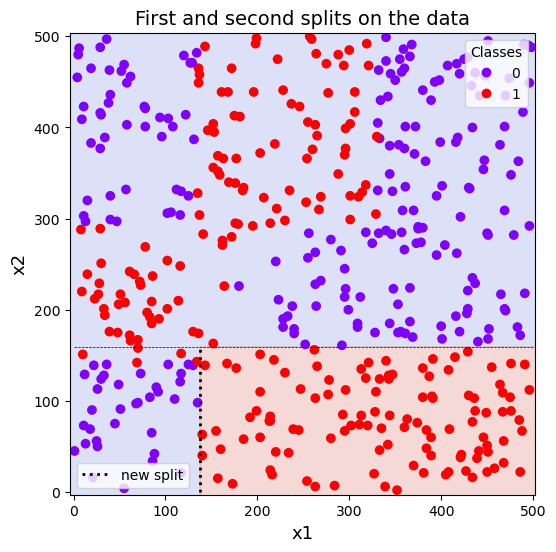

In [ ]:
# Plot the split:
# Create figure of specific size and the axes objects
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter the data points
scatter = ax.scatter(tree_df['x1'], tree_df['x2'], c=tree_df['y'], cmap='rainbow')

# Create a legend object with title "Classes" and specified location on the plot
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Split lines
ax.hlines(x2_threshold, xmin=0, xmax=500,
          color ='black', lw = 0.5, ls='--')
ax.vlines(x1_threshold_2split, ymin=0, ymax=x2_threshold,
          color ='black', lw = 2, ls=':', label='new split')
ax.legend()

# Plot decision regions
# predict class labels on grid points
class_pred = predict_class(xx1, xx2, [('x2', x2_threshold), ('x1', x1_threshold_2split)])
# contour plot for decision regions
plt.contourf(xx1, xx2, class_pred.reshape(xx1.shape), alpha=0.2, zorder=-1, cmap=plt.cm.coolwarm)

# Add labeling to the plot
ax.set_xlabel('x1', fontsize='13')
ax.set_ylabel('x2', fontsize='13')
ax.set_title('First and second splits on the data', fontsize='14');

### Step 4. Stop splitting when the region formed is pure.

Let's split the data and check the values to the right of the threshold:


In [ ]:
first_right_intern_node_df  = first_split_df[first_split_df['x1'] > x1_threshold_2split]
first_right_intern_node_df.head()

,x1,x2,y
0,143,139,1
14,265,138,1
18,230,131,1
20,140,63,1
23,340,144,1


We can see that this region is pure; all the class labels are `1`. There is no need to perform further splits on this region.


In [ ]:
first_right_intern_node_df['y'].value_counts()

y
1    111
Name: count, dtype: int64

### Step 5. Keep doing splits on impure regions.

We stopped spliting on the right child of the second split because it was all one class, however the region represented by the left child is not pure.

In the decision tree algorithm we would keep splitting it recursively till every resulting region will become pure or we encounter another stopping condition, such as max depth.

Use the correct predictor and threshold to subset `first_split_df` to include only those points whose values are in the *left child* of our 2nd split.

Store the resulting dataframe as `second_split_left_df`.


In [ ]:
second_split_left_df  = first_split_df[first_split_df['x1'] <= x1_threshold_2split] # SOLUTION

Observe that *this* node is not pure:

In [ ]:
second_split_left_df['y'].value_counts()

y
0    35
1     5
Name: count, dtype: int64

Let's perform a final split on this impure region.

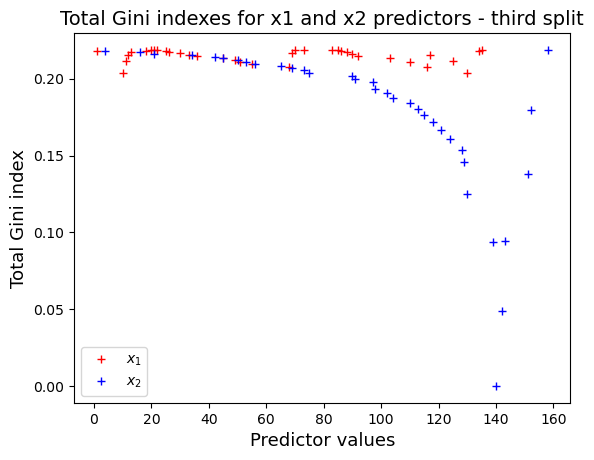

In [ ]:
# Find the predictor and threshold for the split

# get unique values of x1 and x2 in this region
x1_unique_3split = np.unique(second_split_left_df['x1'].values)
x2_unique_3split = np.unique(second_split_left_df['x2'].values)

# Get total gini index for each predictor
tot_gini_x1_3split = get_total_gini(x1_unique_3split, 'x1', second_split_left_df)
tot_gini_x2_3split = get_total_gini(x2_unique_3split, 'x2', second_split_left_df)

plt.plot(x1_unique_3split, tot_gini_x1_3split, 'r+', label='$x_1$')
plt.plot(x2_unique_3split, tot_gini_x2_3split, 'b+', label='$x_2$')
plt.xlabel("Predictor values", fontsize="13")
plt.ylabel("Total Gini index", fontsize="13")
plt.title("Total Gini indexes for x1 and x2 predictors - third split", fontsize="14")
plt.legend();

In [ ]:
report_splits(x1_unique_3split, x2_unique_3split,
              tot_gini_x1_3split, tot_gini_x2_3split)

The lowest total gini score is achieved when splitting on x2 at the value 140.


In [ ]:
### edTest(test_third_threshold) ###

# The value to split on
x2_threshold_3split = get_threshold(x2_unique_3split, tot_gini_x2_3split) # SOLUTION

print("x2 3rd split threshold:", x2_threshold_3split)
# Test that we got the expected result
np.testing.assert_allclose(141.0, x2_threshold_3split)

x2 3rd split threshold: 141.0


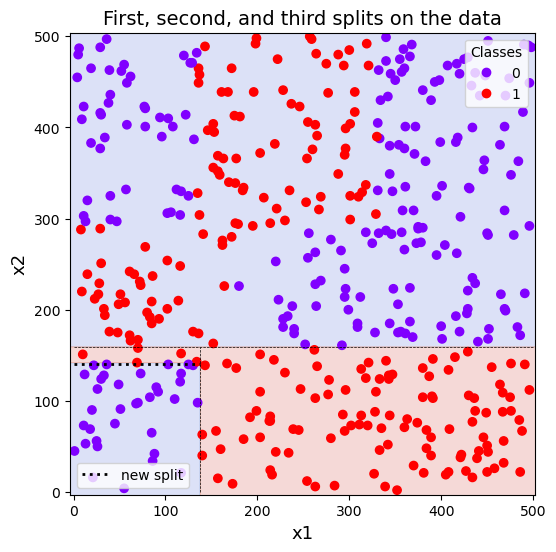

In [ ]:
# Plot the split:
# Create figure of specific size and the axes objects
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter the data points
scatter = ax.scatter(tree_df['x1'], tree_df['x2'], c=tree_df['y'], cmap='rainbow')

# Create a legend object with title "Classes" and specified location on the plot
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Split lines
ax.hlines(x2_threshold, xmin=0, xmax=500,
          color ='black', lw = 0.5, ls='--')
ax.vlines(x1_threshold_2split, ymin=0, ymax=x2_threshold,
          color ='black', lw = 0.5, ls='--')
ax.hlines(x2_threshold_3split, xmin=0, xmax=x1_threshold_2split,
          color ='black', lw = 2, ls=':', label='new split')
ax.legend()

# Plot decision regions
# predict class labels on grid points
class_pred = predict_class(xx1, xx2, [('x2', x2_threshold),
                                      ('x1', x1_threshold_2split),
                                      ('x2', x2_threshold_3split)])
# contour plot for decision regions
plt.contourf(xx1, xx2, class_pred.reshape(xx1.shape), alpha=0.2, zorder=-1, cmap=plt.cm.coolwarm)

# Add labeling to the plot
ax.set_xlabel('x1', fontsize='13')
ax.set_ylabel('x2', fontsize='13')
ax.set_title('First, second, and third splits on the data', fontsize='14');

The two leaf nodes resulting from this split are pure!

In [ ]:
# Perform the split
# Get the left leaf node
left_final_leaf_df  = second_split_left_df[second_split_left_df['x2'] <= x2_threshold_3split]
# Confirm the purity of the final leaf
left_final_leaf_df['y'].value_counts()

y
0    35
Name: count, dtype: int64

In [ ]:
# Get the right leaf node
right_final_leaf_df = second_split_left_df[second_split_left_df['x2'] > x2_threshold_3split]
# Confirm the putity of the final leaf
right_final_leaf_df['y'].value_counts()

y
1    5
Name: count, dtype: int64

## Comparing to SKLearn Implementation
We have just finished the left branch of the decision tree for this data. Now Let's compare our manual results with what sklearn DecisionTreeClassifier class would do. We will use a handy tree module from sklearn to visualize the produced tree.

In [ ]:
# Split data into predictor matrix and target series
X = tree_df[['x1','x2']]
y = tree_df['y']

In [ ]:
# Fit the tree to the data
sklearn_tree = DecisionTreeClassifier(max_depth=3)
sklearn_tree.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


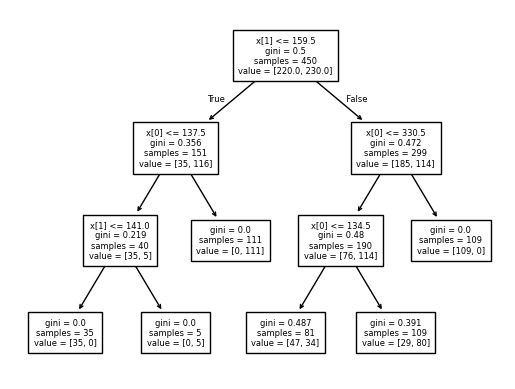

In [ ]:
# Visualize the tree
tree.plot_tree(sklearn_tree, fontsize=6)
plt.show()

**As we can see above the left tree branch on the sklearn tree looks just like what we did manually above!**

---

## COVID Risk Classification Scenarios

Even with the ROC curve as a tool, we cannot really tell which model to use.

What metric matters most for decision‑making?

### Scenario 1 — 🇧🇷 Brazil

In Brazil, the new covid variant is contagious and infects many citizens.
Brazilian officials, however, dictate that hospitals do not classify many people at 'high' risk to avoid bad press and subsequent political global backlash.
To model this scenario well, we need the best classifier with the following restriction:

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/brazil.png?raw=1" alt="News article about the Covid situation in Brazil" style="zoom:50%;" />



**Constraint:**
$$TPR + FPR \le 0.5$$

*Goal:* Limit total positive classifications.

### Scenario 2 — 🇩🇪 Germany

German officials want the fatality ratio to be as low as possible.
Thus, it is imperative to find cases that need urgent attention and give them the best chance of survival.
Thus, we need the best classifier with the following restriction:

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/germany.png?raw=1" alt="News article about the Covid situation in Germany" style="zoom:50%;" />


**Constraint:**
$$TPR \ge 0.85$$

*Goal:* Maximize ability to catch true severe cases.

### Scenario 3 — 🇮🇳 India

India has only 1 million beds left and there are already 2 million people suspected of having the disease.
Officials need to work out a strategy to find the people who are in the most need of urgent care.
This restriction to model this scenario well is the following:


<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/india.png?raw=1" alt="News article about the Covid situation in India" style="zoom:50%;" />

**Constraint:**
$$TPR + FPR \le 1$$

*Goal:* Balanced trade‑off for a constrained healthcare system.

### ROC‑Based Model Choice Discussion

Insert ROC curve and compare classifiers under each constraint.

Given that we have produced a plot similar to the one shown here, we would want to find the best model for each of the three cases.

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/roc_curve.png?raw=1" alt="ROC curve plot for all 3 countries; Brazil, Germany, and India" style="zoom:50%;" />


What the chart means
### Understanding ROC Axes: FPR & TPR

| Axis   | Meaning                                                                     |
| ------ | --------------------------------------------------------------------------- |
| x-axis | False Positive Rate (FPR) — *“how many healthy people we classify as sick”* |
| y-axis | True Positive Rate (TPR) — *“how many sick people we correctly detect”*     |

Higher-left corner = best-performing region.


### Choice of Classifier

Based on the constraints, we have the following choice of classifier:

**BRAZIL** : Logistic regression with a high threshold

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/classification_metrics_bestmodel2.png?raw=1" alt="ROC curve plot for all 3 countries; Brazil, Germany and India - with Brazil threshold highlighted" style="zoom:50%;" />





**GERMANY** : Logistic regression with a low threshold

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/classification_metrics_bestmodel3.png?raw=1" alt="ROC curve plot for all 3 countries; Brazil, Germany and India - with Germany threshold highlighted" style="zoom:50%;" />





**INDIA** : kNN classifier with a moderate threshold

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/classification_metrics_bestmodel4.png?raw=1" alt="ROC curve plot for all 3 countries; Brazil, Germany and India - with India threshold highlighted" style="zoom:50%;" />

## 🧠 Summary

* **Models alone never solve the problem**
* **Policy + context determines the “best” classifier**
* ROC curves + constraints = **decision system**

Different countries → *different operating points, even with the same models.*


---

# Additional material

## Decision Tree Spam Classifier Example

We will be working with a spam email dataset. The dataset has 57 predictors with a response variable called `Spam` that indicates whether an email is spam or not spam. The goal is to be able to create a classifier or method that acts as a spam filter.

In [ ]:
spam_df = pd.read_csv('data/spam.csv')
display(spam_df.head())

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_,char_freq_.1,char_freq_.2,char_freq_.3,char_freq_.4,char_freq_.5,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


The predictors are all quantitative. They represent certain features  of an email like the frequency of the word 'discount.' The we will use the binary `spam` variable in the final column as our response for classification.

Link to description : https://archive.ics.uci.edu/ml/datasets/spambase

#### Split data into train and test

In [ ]:
# Split spam_df into train and test data with a random seed of 109
data_train, data_test = train_test_split(spam_df, random_state=0, test_size=.2, stratify=spam_df.spam)

# Split predictor and response columns
X_train, y_train = data_train.drop(['spam'], axis=1), data_train['spam']
X_test , y_test  = data_test.drop(['spam'] , axis=1), data_test['spam']

print("Shape of Training Set :", data_train.shape)
print("Shape of Testing Set :" , data_test.shape)

Shape of Training Set : (3680, 58)
Shape of Testing Set : (921, 58)


In [ ]:
X_train.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_,char_freq_.1,char_freq_.2,char_freq_.3,char_freq_.4,char_freq_.5,capital_run_length_average,capital_run_length_longest,capital_run_length_total
4544,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.93,0.00,0.00,0.93,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.93,0.0,0.0,0.00,0.0,0.0,0.00,0.93,0.93,0.93,0.0,0.00,0.000,0.163,0.000,0.000,0.000,0.0,1.911,15,65
219,0.00,0.00,0.48,0.0,0.96,0.00,0.0,0.00,0.48,0.0,0.00,0.00,0.0,0.00,0.00,0.96,0.96,0.00,1.44,0.0,0.48,0.0,0.96,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.48,0.00,0.0,0.00,0.000,0.133,0.066,0.468,0.267,0.0,3.315,61,242
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,6.00,0.0,2.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,2.00,0.0,0.00,0.000,0.000,0.000,0.353,0.000,0.0,1.555,4,14
3210,0.02,0.08,0.10,0.0,0.27,0.07,0.0,0.00,0.14,0.0,0.00,0.05,0.0,0.02,0.01,0.02,0.00,0.01,0.05,0.0,0.04,0.0,0.00,0.0,0.48,0.49,0.04,0.0,0.0,0.0,0.0,0.0,0.36,0.0,0.0,0.01,0.45,0.0,0.0,0.01,0.0,0.0,0.04,0.00,0.01,0.00,0.0,0.02,0.221,0.152,0.056,0.000,0.004,0.0,2.630,38,3086
1577,0.00,0.00,0.00,0.0,1.09,0.00,0.0,0.54,0.00,0.0,0.54,1.63,0.0,0.27,0.00,0.00,0.27,0.54,2.18,0.0,0.54,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.27,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.000,0.208,0.000,0.166,0.083,0.0,3.521,114,243


We can check that the proportion of spam cases is roughly evenly represented in both the training and test set.


In [ ]:
#Check Percentage of Spam in Train and Test Set
pct_spam_tr = 100*y_train.mean()
pct_spam_te = 100*y_test.mean()

print(f"Percentage of Spam in Training Set \t : {pct_spam_tr:0.2f}%")
print(f"Percentage of Spam in Testing Set \t : {pct_spam_te:0.2f}%")

Percentage of Spam in Training Set 	 : 39.40%
Percentage of Spam in Testing Set 	 : 39.41%


-----------

#### Fitting an Optimal Single Decision Tree (by Depth)

Here, for each candidate `max_depth` and `criterion` combination, we fit a single tree to our spam training data using 5-fold cross validation.

We store the CV accuracy scores in a DataFrame along with the hyperparmeter settings that generated them.

In [ ]:
#Find optimal depth of trees

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['gini', 'entropy']

first_depth = 2
final_depth = 30
step = 2

results = []
for cur_criterion in criterion:
    for max_depth in range(first_depth, final_depth+1, step):
        dt = DecisionTreeClassifier(criterion=cur_criterion , max_depth=max_depth)
        scores = cross_val_score(estimator=dt, X=X_train, y=y_train, cv=5, n_jobs=-1)

        cur_results = {'criterion': cur_criterion,
                      'depth': max_depth,
                      'all_cv': scores,
                      'mean_cv': scores.mean()}
        results.append(cur_results)
df = pd.DataFrame(results)

In [ ]:
display(df)

,criterion,depth,all_cv,mean_cv
0,gini,2,"[0.8328804347826086, 0.8491847826086957, 0.860...",0.842663
1,gini,4,"[0.8885869565217391, 0.90625, 0.91032608695652...",0.899728
2,gini,6,"[0.9171195652173914, 0.9144021739130435, 0.925...",0.911957
3,gini,8,"[0.9211956521739131, 0.9157608695652174, 0.932...",0.918478
4,gini,10,"[0.9144021739130435, 0.9239130434782609, 0.925...",0.918207
5,gini,12,"[0.9211956521739131, 0.9144021739130435, 0.930...",0.919837
6,gini,14,"[0.9157608695652174, 0.9116847826086957, 0.933...",0.917663
7,gini,16,"[0.90625, 0.9116847826086957, 0.92798913043478...",0.915489
8,gini,18,"[0.9157608695652174, 0.9103260869565217, 0.926...",0.914946
9,gini,20,"[0.9198369565217391, 0.904891304347826, 0.9252...",0.915489


Some dataframe manipulations for our x,y construction for the plot below:

#### CV Accuracy by Max Depth

We can then visualize the validation accuracy for the different hyperparameters.

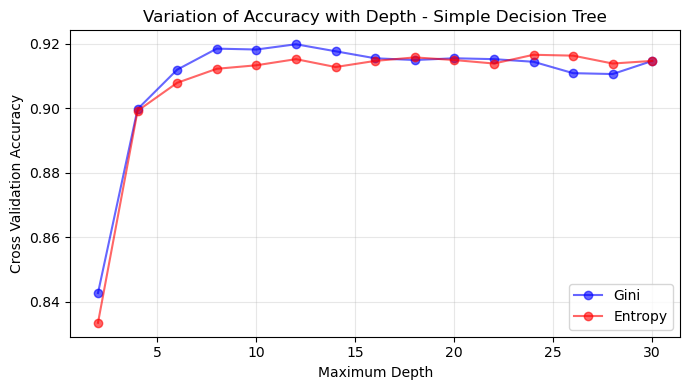

In [ ]:
plt.figure(figsize=(7, 4))

plt.plot(df[df.criterion == 'gini'].depth,
         df[df.criterion == 'gini'].mean_cv, 'b-', marker='o', alpha = 0.6, label='Gini')
plt.plot(df[df.criterion == 'entropy'].depth,
         df[df.criterion == 'entropy'].mean_cv, 'r-', marker='o', alpha = 0.6, label='Entropy')
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
plt.legend()
plt.grid(alpha = 0.3)

plt.tight_layout();

#### Variance of CV Accuracy
Let's visualize a plot with the Confidence Bands!

Also, if we wanted to get **the Confidence Bands of these results**, how would we? It's as simple as a combination of getting variance using ```scores.std()``` and ```plt.fill_between()```.

In [ ]:
df_gini = df[df['criterion'] == 'gini']
df_entropy = df[df['criterion'] == 'entropy']

x_gini = df_gini['depth'].values.astype(float)
y_gini = df_gini['mean_cv'].values.astype(float)

x_entropy = df_entropy['depth'].values.astype(float)
y_entropy = df_entropy['mean_cv'].values.astype(float)

stds_gini = np.array([ np.std(scores) for scores in df_gini['all_cv']], dtype = float)
stds_entropy = np.array([ np.std(scores) for scores in df_entropy['all_cv']], dtype = float)

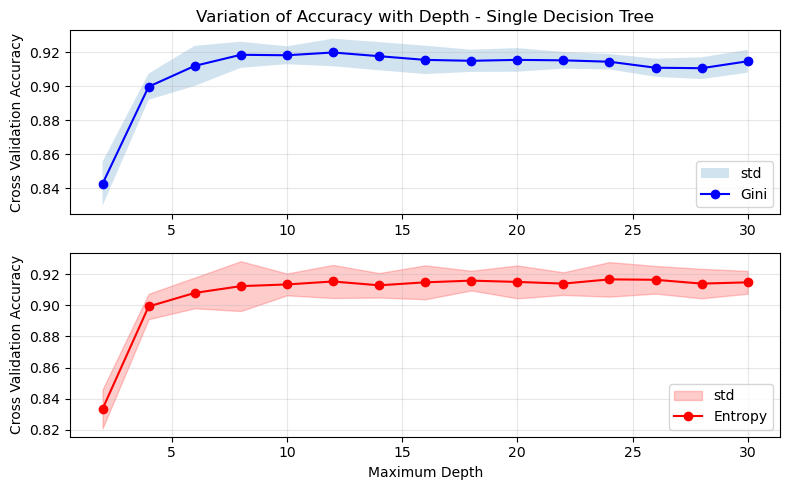

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

#Plot
axes[0].fill_between(df.loc[df.criterion == 'gini'].depth, y_gini + stds_gini,
                     y_gini - stds_gini, alpha=0.2)
axes[0].plot(x_gini, y_gini, 'b-', marker='o')
axes[0].set_ylabel("Cross Validation Accuracy")
axes[0].set_title('Variation of Accuracy with Depth - Single Decision Tree')
axes[0].legend(['std','Gini'])
axes[0].grid(alpha = 0.3)

axes[1].fill_between(x_entropy, y_entropy + stds_entropy,
                     y_entropy - stds_entropy,
                     color = 'r', alpha=0.2)
axes[1].plot(x_entropy, y_entropy, 'r-', marker='o')
axes[1].set_ylabel("Cross Validation Accuracy")
axes[1].set_xlabel("Maximum Depth")
axes[1].legend(['std','Entropy'])
axes[1].grid(alpha = 0.3)

plt.tight_layout();

#### Box plots of CV Ginit Impurity
Let's visualize a boxplot! (**Gini impurity** only)

If we want to display it as a boxplot we first construct a dataframe with all the scores and second we use ```sns.boxplot(...)```

In [ ]:
display(df_gini.head())

,criterion,depth,all_cv,mean_cv
0,gini,2,"[0.8328804347826086, 0.8491847826086957, 0.860...",0.842663
1,gini,4,"[0.8885869565217391, 0.90625, 0.91032608695652...",0.899728
2,gini,6,"[0.9171195652173914, 0.9144021739130435, 0.925...",0.911957
3,gini,8,"[0.9211956521739131, 0.9157608695652174, 0.932...",0.918478
4,gini,10,"[0.9144021739130435, 0.9239130434782609, 0.925...",0.918207


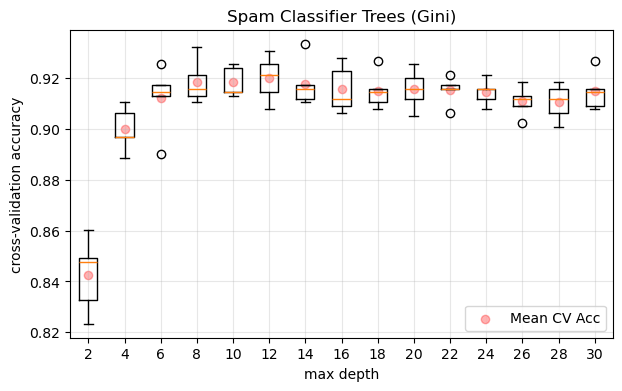

In [ ]:
ds = range(first_depth, final_depth + 1, step)

plt.figure(figsize=(7,4))
plt.boxplot([df_gini.loc[df_gini.depth==d, 'all_cv'].values[0] for d in ds])
plt.scatter(range(1,len(ds)+1), df_gini.mean_cv, color='red', alpha=0.3, label='Mean CV Acc')
plt.xticks(range(1,len(ds)+1), labels=ds)
plt.ylabel("cross-validation accuracy")
plt.xlabel("max depth")
plt.title("Spam Classifier Trees (Gini)")
plt.grid(alpha = 0.3)
plt.legend()
plt.show()

**Question:** Which depth are you going to pick?

#### Best Depth by Metric
**Let's extract the best_depth value from these two dataframes, *df_gini* and *df_entropy*.**

We need to create the new variable *best_depth* for each dataframe.

How to get the index of the maximum value from the given array?

```hint: np.argmax(target array)```

In [ ]:
# What does this do?

mean_CV_acc_gini = df_gini['mean_cv']
mean_CV_acc_entropy = df_entropy['mean_cv']

best_idx_gini = np.argmax(mean_CV_acc_gini)
best_idx_entropy = np.argmax(mean_CV_acc_entropy)

best_depth_gini = df_gini['depth'].iloc[best_idx_gini]
best_depth_entropy = df_entropy['depth'].iloc[best_idx_entropy]

print('The best depth based on Gini impurity was found to be: ', best_depth_gini)
print('The best depth based on Entropy was found to be: ', best_depth_entropy)

The best depth based on Gini impurity was found to be:  12
The best depth based on Entropy was found to be:  24


In [ ]:
#Evalaute the performance at the best depth
model_tree_gini = DecisionTreeClassifier(max_depth=best_depth_gini, criterion = 'gini')
model_tree_entropy = DecisionTreeClassifier(max_depth=best_depth_entropy, criterion ='entropy')

model_tree_gini.fit(X_train, y_train)
model_tree_entropy.fit(X_train, y_train)

#Check Accuracy of Spam Detection in Train and Test Set (Gini Impurity)
acc_trees_train_gini = accuracy_score(y_train, model_tree_gini.predict(X_train))
acc_trees_test_gini  = accuracy_score(y_test,  model_tree_gini.predict(X_test))

print("================ [Gini Impurity] ================")
print("Simple Decision Trees: Accuracy, Training Set \t : {:.2%}".format(acc_trees_train_gini))
print("Simple Decision Trees: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_test_gini))

#Check Accuracy of Spam Detection in Train and Test Set (Entropy)
acc_trees_train_entropy = accuracy_score(y_train, model_tree_entropy.predict(X_train))
acc_trees_test_entropy = accuracy_score(y_test,  model_tree_entropy.predict(X_test))

print("\n================ [Entropy] ================")
print("Simple Decision Trees: Accuracy, Training Set \t : {:.2%}".format(acc_trees_train_entropy))
print("Simple Decision Trees: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_test_entropy))

================ [Gini Impurity] ================
Simple Decision Trees: Accuracy, Training Set 	 : 97.17%
Simple Decision Trees: Accuracy, Testing Set 	 : 91.75%

================ [Entropy] ================
Simple Decision Trees: Accuracy, Training Set 	 : 99.92%
Simple Decision Trees: Accuracy, Testing Set 	 : 90.55%


#### Confusion Matrices
Let's visualize a confusion matrix with ```plot_confusion_matrix```

#### How to visualize the classification result using a Confusion matrix? ####

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/confusion_matrix.png?raw=1" alt="classification error" width="300"/>

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec10/fig/confusion_matrix2.png?raw=1" alt="classification error" width="400"/>

*source: wikipedia*

Here's how can use the sklearn function, **plot_confusion_matrix**.

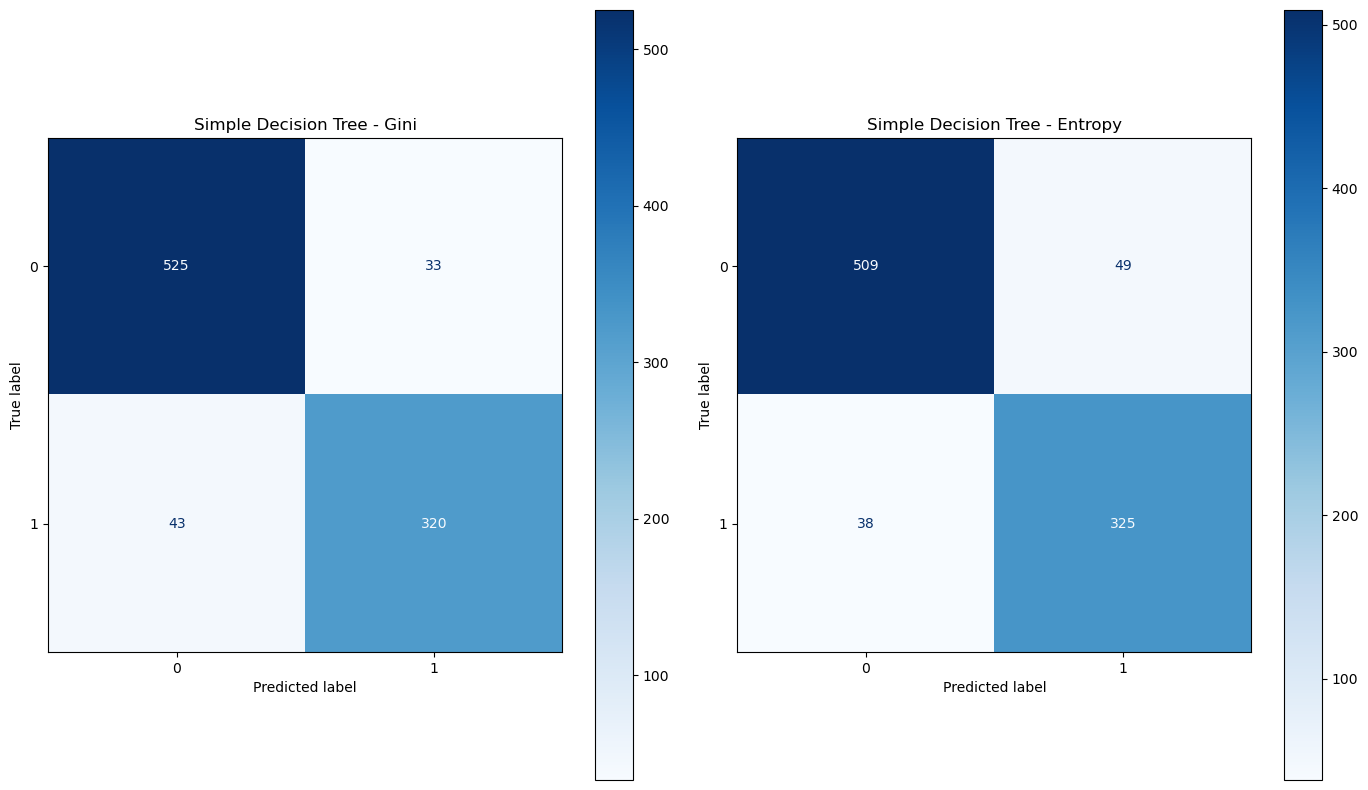

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
ConfusionMatrixDisplay.from_estimator(model_tree_gini, X_test, y_test, cmap=plt.cm.Blues, ax = axes[0]);
ConfusionMatrixDisplay.from_estimator(model_tree_entropy, X_test, y_test, cmap=plt.cm.Blues, ax = axes[1])
axes[0].set_title('Simple Decision Tree - Gini')
axes[1].set_title('Simple Decision Tree - Entropy')
# plt.rc('font', size=18)
plt.tight_layout();

---

## Preprocessing for Decision Trees

Unlike many other models, decision trees have some nice properties when it comes to preprocessing:

1. **Scaling**: Trees don't require feature scaling because they use thresholds rather than distances
   - No need for StandardScaler or MinMaxScaler
   - Trees make splits based on relative ordering, not absolute values

2. **Categorical Variables**:
   - For binary categories, any encoding works equally well
   - For multi-class categories:
     - One-hot encoding is preferred
     - No need to drop_first (unlike linear models) since trees can handle the redundancy
```python
# Example of proper categorical encoding for trees
X_encoded = pd.get_dummies(X, columns=['categorical_column'])
# No need for: drop_first=True
```

3. **Missing Values**:
   - Trees can handle missing values naturally (though sklearn's implementation doesn't)
   - Consider using SimpleImputer with strategy='most_frequent' for categorical
   - Use strategy='median' for numerical features

## Handling Class Imbalances

Class imbalance occurs when some classes have many more samples than others. This is common in real-world scenarios like spam detection or fraud detection. With imbalanced datasets, accuracy can be misleading - a model could achieve high accuracy by simply predicting the majority class!

There are several approaches to handle class imbalances:

1. **Class Weights**: Tell the model to pay more attention to minority classes
   
```python
# Add weights inversely proportional to class frequencies
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
                                   
dt = DecisionTreeClassifier(class_weight='balanced')  # Or pass dict of weights
```

2. **Upsampling**: Replicate minority class samples
```python
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
print('Original dataset shape:', Counter(y_train))
print('Resampled dataset shape:', Counter(y_train_ros))
```

3. **SMOTE**: Create synthetic minority samples (requires a pip install)
```python
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print('Original dataset shape:', Counter(y_train))
print('Resampled dataset shape:', Counter(y_train_sm))
```

## Alternative Metrics to Accuracy (revisted)

When dealing with imbalanced classes, accuracy can be misleading. Consider these alternatives:

1. **Precision**: Of the positive predictions, how many were correct?
   - Important when false positives are costly
   - Example: Spam detection (don't want to block legitimate emails)

2. **Recall**: Of the actual positive cases, how many did we catch?
   - Important when false negatives are costly
   - Example: Disease detection (don't want to miss sick patients)

3. **F1 Score**: Harmonic mean of precision and recall
   - Balances precision and recall

```python
from sklearn.metrics import classification_report

# Get comprehensive metrics
print(classification_report(y_test, y_pred))

# For binary classification, you can of course also plot the ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()
```

**🌈 The End**